In [1]:
import numpy
import torch
import pandas

import math

import pyfaidx
import pyBigWig
import matplotlib.pyplot as plt

from tqdm import tqdm

def one_hot_encode(sequence, alphabet=['A', 'C', 'G', 'T'], dtype='int8', 
	desc=None, verbose=False, **kwargs):
	"""Converts a string or list of characters into a one-hot encoding.

	This function will take in either a string or a list and convert it into a
	one-hot encoding. If the input is a string, each character is assumed to be
	a different symbol, e.g. 'ACGT' is assumed to be a sequence of four 
	characters. If the input is a list, the elements can be any size.

	Although this function will be used here primarily to convert nucleotide
	sequences into one-hot encoding with an alphabet of size 4, in principle
	this function can be used for any types of sequences.

	Parameters
	----------
	sequence : str or list
		The sequence to convert to a one-hot encoding.

	alphabet : set or tuple or list
		A pre-defined alphabet where the ordering of the symbols is the same
		as the index into the returned tensor, i.e., for the alphabet ['A', 'B']
		the returned tensor will have a 1 at index 0 if the character was 'A'.
		Characters outside the alphabet are ignored and none of the indexes are
		set to 1. Default is ['A', 'C', 'G', 'T'].

	dtype : str or numpy.dtype, optional
		The data type of the returned encoding. Default is int8.

	desc : str or None, optional
		The title to display in the progress bar.

	verbose : bool or str, optional
		Whether to display a progress bar. If a string is passed in, use as the
		name of the progressbar. Default is False.

	kwargs : arguments
		Arguments to be passed into tqdm. Default is None.

	Returns
	-------
	ohe : numpy.ndarray
		A binary matrix of shape (alphabet_size, sequence_length) where
		alphabet_size is the number of unique elements in the sequence and
		sequence_length is the length of the input sequence.
	"""

	d = verbose is False

	if isinstance(sequence, str):
		sequence = list(sequence)

	alphabet_lookup = {char: i for i, char in enumerate(alphabet)}

	ohe = numpy.zeros((len(sequence), len(alphabet)), dtype=dtype)
	for i, char in tqdm(enumerate(sequence), disable=d, desc=desc, **kwargs):
		idx = alphabet_lookup.get(char, -1)
		if idx != -1:
			ohe[i, idx] = 1

	return ohe

def extract_loci(loci, sequences, signals=None, controls=None, chroms=None, 
	in_window=2114, out_window=1000, max_jitter=0, min_counts=None,
	max_counts=None, n_loci=None, verbose=False):
	"""Extract sequences and signals at coordinates from a locus file.

	This function will take in genome-wide sequences, signals, and optionally
	controls, and extract the values of each at the coordinates specified in
	the locus file/s and return them as tensors.

	Signals and controls are both lists with the length of the list, n_s
	and n_c respectively, being the middle dimension of the returned
	tensors. Specifically, the returned tensors of size 
	(len(loci), n_s/n_c, (out_window/in_wndow)+max_jitter*2).

	The values for sequences, signals, and controls, can either be filepaths
	or dictionaries of numpy arrays or a mix of the two. When a filepath is 
	passed in it is loaded using pyfaidx or pyBigWig respectively.   

	Parameters
	----------
	loci: str or pandas.DataFrame or list/tuple of such
		Either the path to a bed file or a pandas DataFrame object containing
		three columns: the chromosome, the start, and the end, of each locus
		to train on. Alternatively, a list or tuple of strings/DataFrames where
		the intention is to train on the interleaved concatenation, i.e., when
		you want to train on peaks and negatives.

	sequences: str or dictionary
		Either the path to a fasta file to read from or a dictionary where the
		keys are the unique set of chromosoms and the values are one-hot
		encoded sequences as numpy arrays or memory maps.

	signals: list of strs or list of dictionaries or None, optional
		A list of filepaths to bigwig files, where each filepath will be read
		using pyBigWig, or a list of dictionaries where the keys are the same
		set of unique chromosomes and the values are numpy arrays or memory
		maps. If None, no signal tensor is returned. Default is None.

	controls: list of strs or list of dictionaries or None, optional
		A list of filepaths to bigwig files, where each filepath will be read
		using pyBigWig, or a list of dictionaries where the keys are the same
		set of unique chromosomes and the values are numpy arrays or memory
		maps. If None, no control tensor is returned. Default is None. 

	chroms: list or None, optional
		A set of chromosomes to extact loci from. Loci in other chromosomes
		in the locus file are ignored. If None, all loci are used. Default is
		None.

	in_window: int, optional
		The input window size. Default is 2114.

	out_window: int, optional
		The output window size. Default is 1000.

	max_jitter: int, optional
		The maximum amount of jitter to add, in either direction, to the
		midpoints that are passed in. Default is 0.

	min_counts: float or None, optional
		The minimum number of counts, summed across the length of each example
		and across all tasks, needed to be kept. If None, no minimum. Default 
		is None.

	max_counts: float or None, optional
		The maximum number of counts, summed across the length of each example
		and across all tasks, needed to be kept. If None, no maximum. Default 
		is None.  

	n_loci: int or None, optional
		A cap on the number of loci to return. Note that this is not the
		number of loci that are considered. The difference is that some
		loci may be filtered out for various reasons, and those are not
		counted towards the total. If None, no cap. Default is None.

	verbose: bool, optional
		Whether to display a progress bar while loading. Default is False.

	Returns
	-------
	seqs: torch.tensor, shape=(n, 4, in_window+2*max_jitter)
		The extracted sequences in the same order as the loci in the locus
		file after optional filtering by chromosome.

	signals: torch.tensor, shape=(n, len(signals), out_window+2*max_jitter)
		The extracted signals where the first dimension is in the same order
		as loci in the locus file after optional filtering by chromosome and
		the second dimension is in the same order as the list of signal files.
		If no signal files are given, this is not returned.

	controls: torch.tensor, shape=(n, len(controls), out_window+2*max_jitter)
		The extracted controls where the first dimension is in the same order
		as loci in the locus file after optional filtering by chromosome and
		the second dimension is in the same order as the list of control files.
		If no control files are given, this is not returned.
	"""

	seqs, signals_, controls_ = [], [], []
	in_width, out_width = in_window // 2, out_window // 2

	# Load the sequences
	if isinstance(sequences, str):
		sequences = pyfaidx.Fasta(sequences)

	names = ['chrom', 'start', 'end']
	if not isinstance(loci, (tuple, list)):
		loci = [loci]

	loci_dfs = []
	for i, df in enumerate(loci):
	    if isinstance(df, str):
	        df = pandas.read_csv(df, sep='\t', usecols=[0, 1, 2], 
	            header=None, index_col=False, names=names)
	        df['idx'] = numpy.arange(len(df)) * len(loci) + i

	    loci_dfs.append(df)

	loci = pandas.concat(loci_dfs).set_index("idx").sort_index().reset_index(drop=True)

	if chroms is not None:
		loci = loci[numpy.isin(loci['chrom'], chroms)]

	# Load the signal and optional control tracks if filenames are given
	_signals = []
	if signals is not None:
		for i, signal in enumerate(signals):
			if isinstance(signal, str):
				signal = pyBigWig.open(signal)
			_signals.append(signal)

		signals = _signals
				
	_controls = []
	if controls is not None:
		for i, control in enumerate(controls):
			if isinstance(control, str):
				control = pyBigWig.open(control, "r")
			_controls.append(control)
			
		controls = _controls

	desc = "Loading Loci"
	d = not verbose

	max_width = max(in_width, out_width)
	loci_count = 0

	print(loci)
	print(loci.values)
	for chrom, start, end in tqdm(loci.values, disable=d, desc=desc):
		mid = start + (end - start) // 2

		if start - max_width - max_jitter < 0:
			continue

		if end + max_width + max_jitter >= len(sequences[chrom]):
			continue

		if n_loci is not None and loci_count == n_loci:
			break 

		start = mid - out_width - max_jitter
		end = mid + out_width + max_jitter

		# Extract the signal from each of the signal files
		if signals is not None:
			signals_.append([])
			for signal in signals:
				if isinstance(signal, dict):
					signal_ = signal[chrom][start:end]
				else:
					signal_ = signal.values(chrom, start, end, numpy=True)
					signal_ = numpy.nan_to_num(signal_)

				signals_[-1].append(signal_)

		# For the sequences and controls extract a window the size of the input
		start = mid - in_width - max_jitter
		end = mid + in_width + max_jitter

		# Extract the controls from each of the control files
		if controls is not None:
			controls_.append([])
			for control in controls:
				if isinstance(control, dict):
					control_ = control[chrom][start:end]
				else:
					control_ = control.values(chrom, start, end, numpy=True)
					control_ = numpy.nan_to_num(control_)

				controls_[-1].append(control_)

		# Extract the sequence
		if isinstance(sequences, dict):
			seq = sequences[chrom][start:end].T
		else:
			seq = one_hot_encode(sequences[chrom][start:end].seq.upper(), 
				alphabet=['A', 'C', 'G', 'T']).T
		
		seqs.append(seq)
		loci_count += 1

	seqs = torch.tensor(numpy.array(seqs), dtype=torch.float32)

	if signals is not None:
		signals_ = torch.tensor(numpy.array(signals_), dtype=torch.float32)

		idxs = torch.ones(signals_.shape[0], dtype=torch.bool)
		if max_counts is not None:
			idxs = (idxs) & (signals_.sum(dim=(1, 2)) < max_counts)
		if min_counts is not None:
			idxs = (idxs) & (signals_.sum(dim=(1, 2)) > min_counts)

		if controls is not None:
			controls_ = torch.tensor(numpy.array(controls_), dtype=torch.float32)
			return seqs[idxs], signals_[idxs], controls_[idxs]

		return seqs[idxs], signals_[idxs]
	else:
		if controls is not None:
			controls_ = torch.tensor(numpy.array(controls_), dtype=torch.float32)
			return seqs, controls_

		return seqs
    

In [2]:
def extract_histone(cell_line, histone):
    """ Given the names of a cell line and histone mark, extracts the histone marks at the given cell and returns 
    a tensor.
    
    Parameters
    ----------
    cell_line: String
        Describes the cell line that we are going to extract histone marks from (ex: 'HUVEC')
    histone: String
        Describes the histone mark that we are going to extract (ex: 'H3K27ac')
    """

    _, actual = extract_loci(merged_peak_path, sequences, signals=[histone_paths[histone][cell_line]],
                             controls=None, chroms=None, in_window=2114, out_window=1000, max_jitter=0)

    flattened = torch.sum(torch.sum(actual, dim=1), dim=1)
    return(flattened)
    
    
def getcorrelation(cell_line1, cell_line2, histone):
    """ Given two different cell lines, calculates correlation between distance to x=y line and
    histone marks and returns the correlation between the histone marks in cell 1 and also the correlation
    between the histone marks in cell 2.
    
    Parameters
    ----------
    cell_line1: String
        Describes the cell line that we are going to extract trans. init. from (ex: 'HUVEC')
    cell_line2: String
        Describes the second cell line that we are going to extract trans. init. from (ex: 'HUVEC')
    histone: String
        Describes the histone mark that we are going to extract (ex: 'H3K27ac')
    """
    #xy_deviance = [float(abs(log_initiation_levels[cell_line1][i] - log_initiation_levels[cell_line2][i])/math.sqrt(2)) for i in range(len(log_initiation_levels[cell_line1]))]
    xy_deviance = [log_initiation_levels[cell_line1][i] - log_initiation_levels[cell_line2][i] for i in range(len(log_initiation_levels[cell_line1]))]
    
    corr1 = numpy.corrcoef(histones[histone][cell_line1], xy_deviance)[0][1]
    corr2 = numpy.corrcoef(histones[histone][cell_line2], xy_deviance)[0][1]
    return corr1, corr2


def graph_withcorrelations(cell_line1, cell_line2, histone):
    corrs = getcorrelation(cell_line1, cell_line2, histone)
    
    print("Correlation between", cell_line1, "&", cell_line2, "with regards to", cell_line1, "histone marks is", corrs[0])
    plt.scatter(log_initiation_levels[cell_line1], log_initiation_levels[cell_line2], c=log_histones[histone][cell_line1],
            s=0.3, cmap='viridis')
    plt.show()
    
    print("Correlation between", cell_line1, "&", cell_line2, "with regards to", cell_line2, "histone marks is", corrs[1])
    plt.scatter(log_initiation_levels[cell_line1], log_initiation_levels[cell_line2], c=log_histones[histone][cell_line2],
            s=0.3, cmap='viridis')
    plt.colorbar()
    plt.show()


In [3]:
root = "/home/myin25/celltype_specificity/celltype_specificity/"

cell_types = ['K562', 'CACO2','A673', 'HUVEC']
sequences = root + "refs/hg38.fasta"
merged_peak_path = root + "data/procap/union_peaks_fold1_train.bed.gz"

# Histone folders
histonefolders = {'K562': root + "data/K562",
                  'CACO2': root + "data/CACO2",
                  'A673': root + "data/A673",
                  'HUVEC': root + "data/HUVEC"}

# Paths to different histones
histone_paths = {'H3K9me3':{'K562': histonefolders['K562'] + "/H3K9me3/foldchange.bigWig",
                 'CACO2':histonefolders['CACO2'] + "/H3K9me3/foldchange.bigWig",
                 'A673':histonefolders['A673'] + "/H3K9me3/foldchange.bigWig",
                 'HUVEC':histonefolders['HUVEC'] + "/H3K9me3/foldchange.bigWig"},
                 
                 'H3K4me1':{'K562': histonefolders['K562'] + "/H3K4me1/foldchange.bigWig",
                 'CACO2':histonefolders['CACO2'] + "/H3K4me1/foldchange.bigWig",
                 'A673':histonefolders['A673'] + "/H3K4me1/foldchange.bigWig",
                 'HUVEC':histonefolders['HUVEC'] + "/H3K4me1/foldchange.bigWig"},
                 
                 'H3K27me3':{'K562': histonefolders['K562'] + "/H3K27me3/foldchange.bigWig",
                 'CACO2':histonefolders['CACO2'] + "/H3K27me3/foldchange.bigWig",
                 'A673':histonefolders['A673'] + "/H3K27me3/foldchange.bigWig",
                 'HUVEC':histonefolders['HUVEC'] + "/H3K27me3/foldchange.bigWig"},
                 
                 'H3K27ac':{'K562': histonefolders['K562'] + "/H3K27ac/foldchange.bigWig",
                 'CACO2':histonefolders['CACO2'] + "/H3K27ac/foldchange.bigWig",
                 'A673':histonefolders['A673'] + "/H3K27ac/foldchange.bigWig",
                 'HUVEC':histonefolders['HUVEC'] + "/H3K27ac/foldchange.bigWig"},
                 
                 'H3K36me3':{'K562': histonefolders['K562'] + "/H3K36me3/foldchange.bigWig",
                 'CACO2':histonefolders['CACO2'] + "/H3K36me3/foldchange.bigWig",
                 'A673':histonefolders['A673'] + "/H3K36me3/foldchange.bigWig",
                 'HUVEC':histonefolders['HUVEC'] + "/H3K36me3/foldchange.bigWig"},
                 
                 'H3K4me3':{'K562': histonefolders['K562'] + "/H3K4me3/foldchange.bigWig",
                 'CACO2':histonefolders['CACO2'] + "/H3K4me3/foldchange.bigWig",
                 'A673':histonefolders['A673'] + "/H3K4me3/foldchange.bigWig",
                 'HUVEC':histonefolders['HUVEC'] + "/H3K4me3/foldchange.bigWig"},
                 
                 'H3K9ac':{'K562': histonefolders['K562'] + "/H3K9ac/foldchange.bigWig",
                 'CACO2':histonefolders['CACO2'] + "/H3K9ac/foldchange.bigWig",
                 'A673':histonefolders['A673'] + "/H3K9ac/foldchange.bigWig",
                 'HUVEC':histonefolders['HUVEC'] + "/H3K9ac/foldchange.bigWig"},
                 
                 'H3K79me2':{'K562': histonefolders['K562'] + "/H3K79me2/foldchange.bigWig",
                 'CACO2':histonefolders['CACO2'] + "/H3K79me2/foldchange.bigWig",
                 'A673':histonefolders['A673'] + "/H3K79me2/foldchange.bigWig",
                 'HUVEC':histonefolders['HUVEC'] + "/H3K79me2/foldchange.bigWig"}}

# Observed transcription initiation levels across different cell lines
peak_paths = {cell_type : root + "data/procap/observed/{}/peaks.bed.gz".format(cell_type) for cell_type in cell_types}
levels_actual_path = {'K562' : [root + "data/procap/observed/K562/5prime.neg.bigWig", root + "data/procap/observed/K562/5prime.pos.bigWig"],
                       'CACO2' : [root + "data/procap/observed/CACO2/5prime.neg.bigWig", root + "data/procap/observed/CACO2/5prime.pos.bigWig"],
                       'A673' : [root + "data/procap/observed/A673/5prime.neg.bigWig", root + "data/procap/observed/A673/5prime.pos.bigWig"],
                       'HUVEC' : [root + "data/procap/observed/HUVEC/5prime.neg.bigWig", root + "data/procap/observed/HUVEC/5prime.pos.bigWig"]}

# Load the transcription initiation values
# Load the actual initiation values
initiation_levels = {'K562' : torch.sum(torch.sum(extract_loci(merged_peak_path, sequences, signals=levels_actual_path['K562'],
                           controls=None, chroms=None, in_window=2114, out_window=1000, max_jitter=0)[1], dim=1), dim=1),
                     'CACO2' : torch.sum(torch.sum(extract_loci(merged_peak_path, sequences, signals=levels_actual_path['CACO2'],
                           controls=None, chroms=None, in_window=2114, out_window=1000, max_jitter=0)[1], dim=1), dim=1),
                     'A673' : torch.sum(torch.sum(extract_loci(merged_peak_path, sequences, signals=levels_actual_path['A673'],
                           controls=None, chroms=None, in_window=2114, out_window=1000, max_jitter=0)[1], dim=1), dim=1),
                     'HUVEC' : torch.sum(torch.sum(extract_loci(merged_peak_path, sequences, signals=levels_actual_path['HUVEC'],
                           controls=None, chroms=None, in_window=2114, out_window=1000, max_jitter=0)[1], dim=1), dim=1)}

log_initiation_levels = {'K562' : torch.log1p(initiation_levels['K562']),
                         'CACO2' : torch.log1p(initiation_levels['CACO2']),
                         'A673' : torch.log1p(initiation_levels['A673']),
                         'HUVEC' : torch.log1p(initiation_levels['HUVEC'])}


       chrom      start        end
0       chr5  174600055  174600190
1      chr15  101266186  101266192
2       chr5  178730466  178730886
3       chr8  141265328  141265430
4      chr11  122101677  122102099
...      ...        ...        ...
77104  chr10    8057680    8057768
77105   chrX   54495467   54495991
77106   chr5  141223214  141223515
77107   chr5   70586204   70586249
77108   chr5  141557700  141558018

[77109 rows x 3 columns]
[['chr5' 174600055 174600190]
 ['chr15' 101266186 101266192]
 ['chr5' 178730466 178730886]
 ...
 ['chr5' 141223214 141223515]
 ['chr5' 70586204 70586249]
 ['chr5' 141557700 141558018]]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-53ba458c2ea7>", line 64, in <module>
    controls=None, chroms=None, in_window=2114, out_window=1000, max_jitter=0)[1], dim=1), dim=1),
  File "<ipython-input-1-977172d29f15>", line 271, in extract_loci
    alphabet=['A', 'C', 'G', 'T']).T
  File "<ipython-input-1-977172d29f15>", line 62, in one_hot_encode
    sequence = list(sequence)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (m

TypeError: object of type 'NoneType' has no len()

In [ ]:
histones = {'H3K9me3':{'K562': extract_histone('K562', 'H3K9me3'),
                 'CACO2':extract_histone('CACO2', 'H3K9me3'),
                 'A673':extract_histone('A673', 'H3K9me3'),
                 'HUVEC':extract_histone('HUVEC', 'H3K9me3')},
                 
                 'H3K4me1':{'K562': extract_histone('K562', 'H3K4me1'),
                 'CACO2':extract_histone('CACO2', 'H3K4me1'),
                 'A673':extract_histone('A673', 'H3K4me1'),
                 'HUVEC':extract_histone('HUVEC', 'H3K4me1')},
                 
                 'H3K27me3':{'K562': extract_histone('K562', 'H3K27me3'),
                 'CACO2':extract_histone('CACO2', 'H3K27me3'),
                 'A673':extract_histone('A673', 'H3K27me3'),
                 'HUVEC':extract_histone('HUVEC', 'H3K27me3')},
                 
                 'H3K27ac':{'K562': extract_histone('K562', 'H3K27ac'),
                 'A673':extract_histone('A673', 'H3K27ac'),
                 'HUVEC':extract_histone('HUVEC', 'H3K27ac')},
                 
                 'H3K36me3':{'K562': extract_histone('K562', 'H3K36me3'),
                 'CACO2':extract_histone('CACO2', 'H3K36me3'),
                 'A673':extract_histone('A673', 'H3K36me3'),
                 'HUVEC':extract_histone('HUVEC', 'H3K36me3')},
                 
                 'H3K4me3':{'K562': extract_histone('K562', 'H3K4me3'),
                 'CACO2':extract_histone('CACO2', 'H3K4me3'),
                 'A673':extract_histone('A673', 'H3K4me3'),
                 'HUVEC':extract_histone('HUVEC', 'H3K4me3')},
                 
                 'H3K9ac':{'K562': extract_histone('K562', 'H3K9ac'),
                 'HUVEC':extract_histone('HUVEC', 'H3K9ac')},
                 
                 'H3K79me2':{'K562': extract_histone('K562', 'H3K79me2'),
                 'HUVEC':extract_histone('HUVEC', 'H3K79me2')}}

In [ ]:
log_histones = {'H3K9me3':{cell_type:torch.log1p(histones['H3K9me3'][cell_type]) for cell_type in cell_types},
                 
                 'H3K4me1':{cell_type:torch.log1p(histones['H3K4me1'][cell_type]) for cell_type in cell_types},
                 
                 'H3K27me3':{cell_type:torch.log1p(histones['H3K27me3'][cell_type]) for cell_type in cell_types},
                 
                 'H3K27ac':{cell_type:torch.log1p(histones['H3K27ac'][cell_type]) for cell_type in ['K562', 'A673', 'HUVEC']},
                 
                 'H3K36me3':{cell_type:torch.log1p(histones['H3K36me3'][cell_type]) for cell_type in cell_types},
                 
                 'H3K4me3':{cell_type:torch.log1p(histones['H3K4me3'][cell_type]) for cell_type in cell_types},
                 
                 'H3K9ac':{cell_type:torch.log1p(histones['H3K9ac'][cell_type]) for cell_type in ['K562', 'HUVEC']},
                 
                 'H3K79me2':{cell_type:torch.log1p(histones['H3K79me2'][cell_type]) for cell_type in ['K562', 'HUVEC']}}


Correlation between K562 & CACO2 with regards to K562 histone marks is -0.027530280808224613


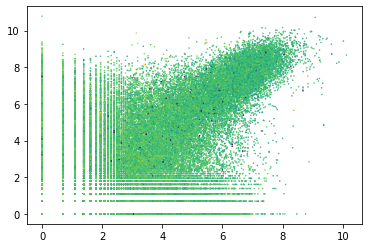

Correlation between K562 & CACO2 with regards to CACO2 histone marks is 0.03284674669350991


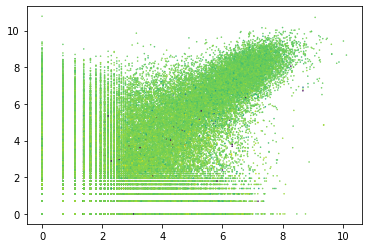

In [36]:
# Plot K562 vs CACO2 initiation levels with histone marks from H3K9me3
graph_withcorrelations('K562', 'CACO2', 'H3K9me3')

Correlation between K562 & A673 with regards to K562 histone marks is -0.11449409638998195


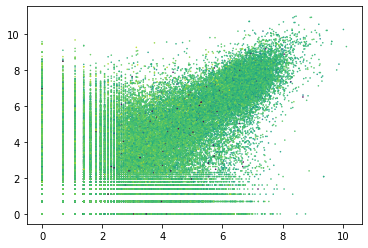

Correlation between K562 & A673 with regards to A673 histone marks is 0.03591488344084181


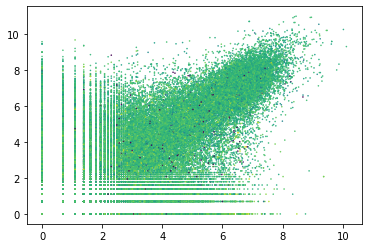

In [37]:
# Plot K562 vs A673 initiation levels with histone marks from H3K9me3
graph_withcorrelations('K562', 'A673', 'H3K9me3')

Correlation between K562 & HUVEC with regards to K562 histone marks is -0.05038839178894269


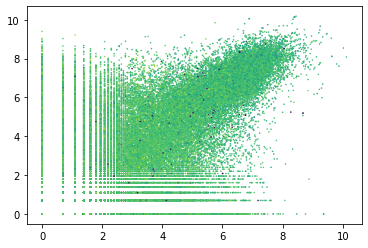

Correlation between K562 & HUVEC with regards to HUVEC histone marks is 0.14840619631543175


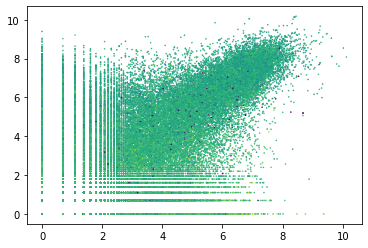

In [38]:
# Plot K562 vs HUVEC initiation levels with histone marks from H3K9me3
graph_withcorrelations('K562', 'HUVEC', 'H3K9me3')

Correlation between CACO2 & A673 with regards to CACO2 histone marks is -0.05063438886373943


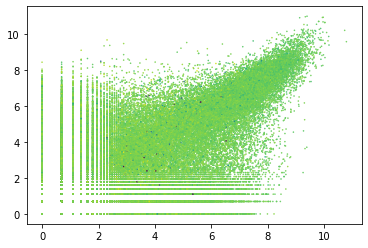

Correlation between CACO2 & A673 with regards to A673 histone marks is -0.014720761191188666


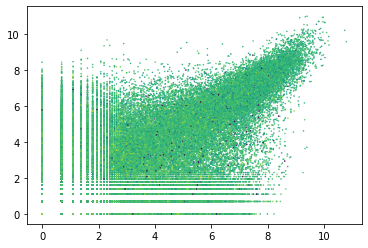

In [39]:
# Plot CACO2 vs A673 initiation levels with histone marks from H3K9me3
graph_withcorrelations('CACO2', 'A673', 'H3K9me3')

Correlation between CACO2 & HUVEC with regards to CACO2 histone marks is -0.0034430099077937056


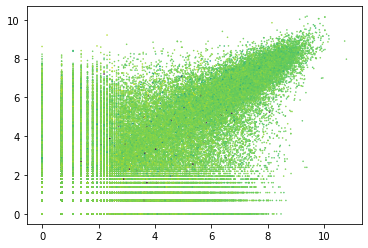

Correlation between CACO2 & HUVEC with regards to HUVEC histone marks is 0.10830269267657973


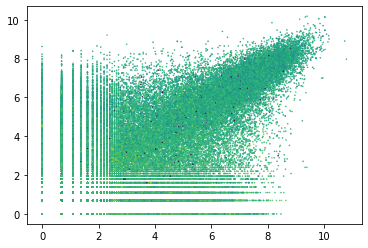

In [40]:
# Plot CACO2 vs HUVEC initiation levels with histone marks from H3K9me3
graph_withcorrelations('CACO2', 'HUVEC', 'H3K9me3')

Correlation between A673 & HUVEC with regards to A673 histone marks is 0.016000827559385408


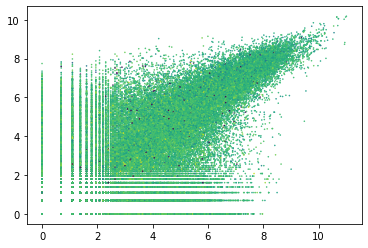

Correlation between A673 & HUVEC with regards to HUVEC histone marks is 0.22675864509044036


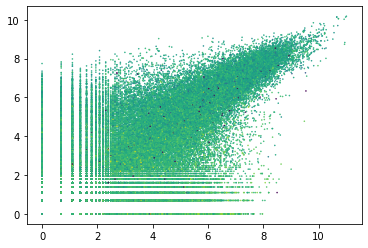

In [41]:
# Plot A673 vs HUVEC initiation levels with histone marks from H3K9me3
graph_withcorrelations('A673', 'HUVEC', 'H3K9me3')

Correlation between K562 & CACO2 with regards to K562 histone marks is 0.050028409778146626


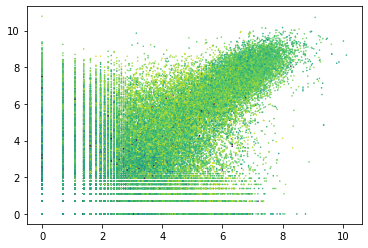

Correlation between K562 & CACO2 with regards to CACO2 histone marks is -0.35537230635184186


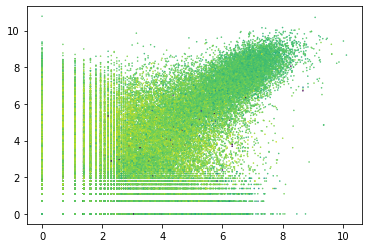

In [42]:
# Plot K562 vs CACO2 initiation levels with histone marks from H3K4me1
graph_withcorrelations('K562', 'CACO2', 'H3K4me1')

Correlation between K562 & A673 with regards to K562 histone marks is 0.1444250585002966


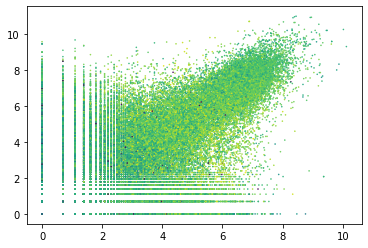

Correlation between K562 & A673 with regards to A673 histone marks is -0.3944171495554614


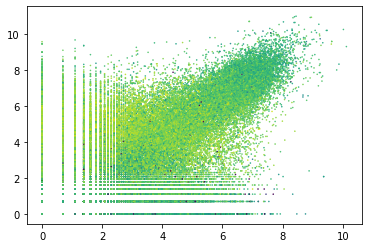

In [43]:
# Plot K562 vs A673 initiation levels with histone marks from H3K4me1
graph_withcorrelations('K562', 'A673', 'H3K4me1')

Correlation between K562 & HUVEC with regards to K562 histone marks is 0.029904150932122633


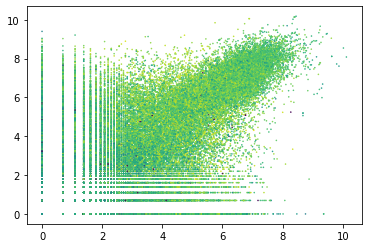

Correlation between K562 & HUVEC with regards to HUVEC histone marks is -0.4257693493661596


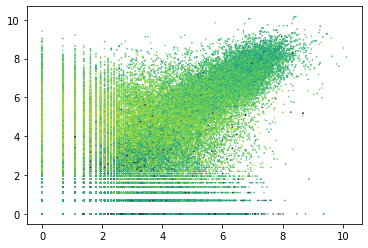

In [44]:
# Plot K562 vs HUVEC initiation levels with histone marks from H3K4me1
graph_withcorrelations('K562', 'HUVEC', 'H3K4me1')

Correlation between CACO2 & A673 with regards to CACO2 histone marks is 0.42063853885288227


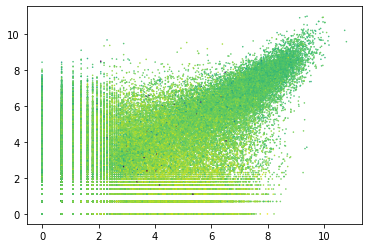

Correlation between CACO2 & A673 with regards to A673 histone marks is -0.4261219053673014


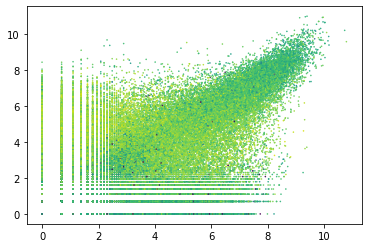

In [45]:
# Plot CACO2 vs A673 initiation levels with histone marks from H3K4me1
graph_withcorrelations('CACO2', 'A673', 'H3K4me1')

Correlation between CACO2 & HUVEC with regards to CACO2 histone marks is 0.3503998209815235


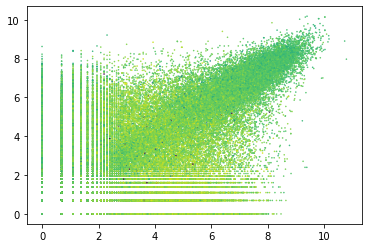

Correlation between CACO2 & HUVEC with regards to HUVEC histone marks is -0.44525062009004535


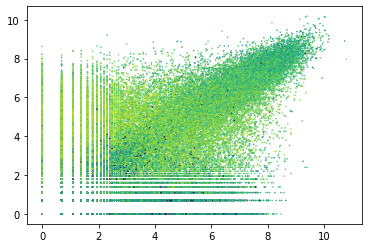

In [46]:
# Plot CACO2 vs HUVEC initiation levels with histone marks from H3K4me1
graph_withcorrelations('CACO2', 'HUVEC', 'H3K4me1')

Correlation between A673 & HUVEC with regards to A673 histone marks is 0.31667459626994915


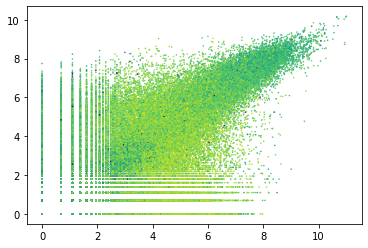

Correlation between A673 & HUVEC with regards to HUVEC histone marks is -0.35341559402169326


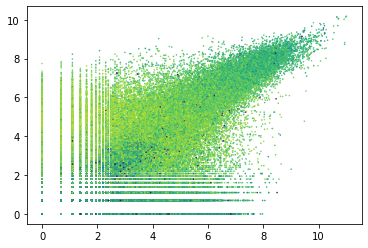

In [47]:
# Plot A673 vs HUVEC initiation levels with histone marks from H3K4me1
graph_withcorrelations('A673', 'HUVEC', 'H3K4me1')

Correlation between K562 & CACO2 with regards to K562 histone marks is -0.2831013745906551


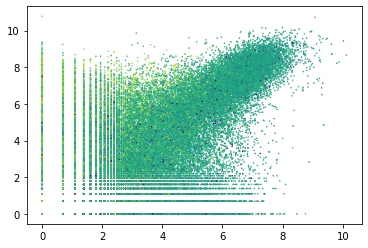

Correlation between K562 & CACO2 with regards to CACO2 histone marks is 0.09831873459780173


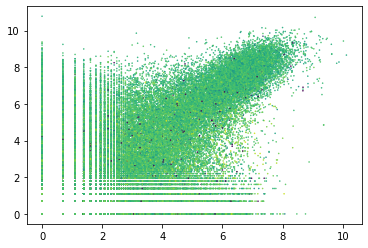

In [48]:
# Plot K562 vs CACO2 initiation levels with histone marks from H3K27me3
graph_withcorrelations('K562', 'CACO2', 'H3K27me3')

Correlation between K562 & A673 with regards to K562 histone marks is -0.23841748658880735


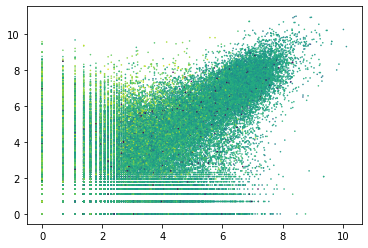

Correlation between K562 & A673 with regards to A673 histone marks is 0.05989971835756797


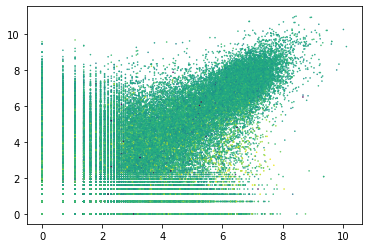

In [49]:
# Plot K562 vs A673 initiation levels with histone marks from H3K27me3
graph_withcorrelations('K562', 'A673', 'H3K27me3')

Correlation between K562 & HUVEC with regards to K562 histone marks is -0.265816063084134


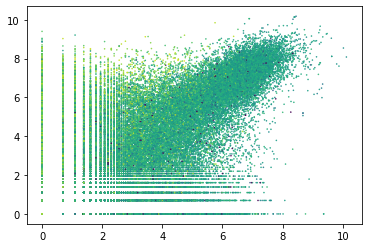

Correlation between K562 & HUVEC with regards to HUVEC histone marks is 0.16269178229928585


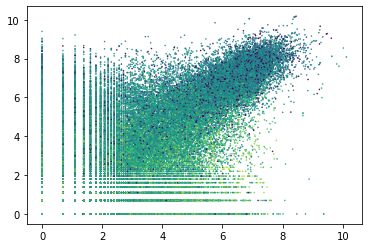

In [50]:
# Plot K562 vs HUVEC initiation levels with histone marks from H3K27me3
graph_withcorrelations('K562', 'HUVEC', 'H3K27me3')

Correlation between CACO2 & A673 with regards to CACO2 histone marks is -0.20823918476631212


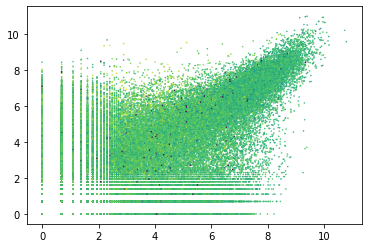

Correlation between CACO2 & A673 with regards to A673 histone marks is 0.16922802384636376


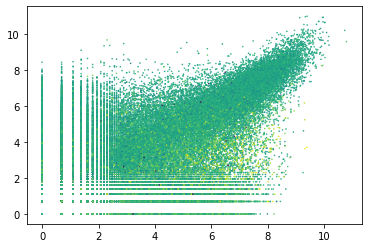

In [51]:
# Plot CACO2 vs A673 initiation levels with histone marks from H3K27me3
graph_withcorrelations('CACO2', 'A673', 'H3K27me3')

Correlation between CACO2 & HUVEC with regards to CACO2 histone marks is -0.1514379141242975


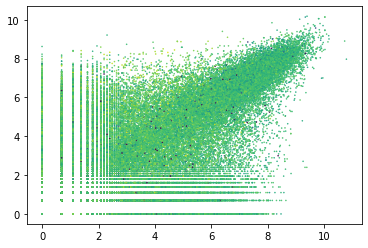

Correlation between CACO2 & HUVEC with regards to HUVEC histone marks is 0.24730489797470454


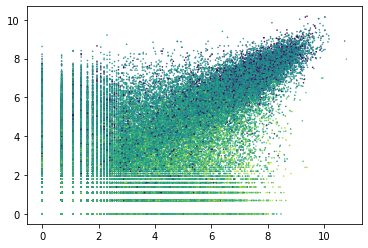

In [52]:
# Plot CACO2 vs HUVEC initiation levels with histone marks from H3K27me3
graph_withcorrelations('CACO2', 'HUVEC', 'H3K27me3')

Correlation between A673 & HUVEC with regards to A673 histone marks is -0.1304792057608786


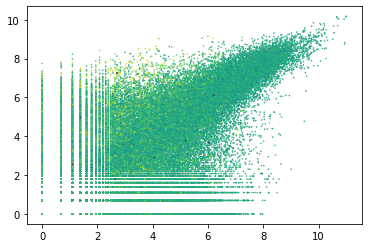

Correlation between A673 & HUVEC with regards to HUVEC histone marks is 0.2574379061870173


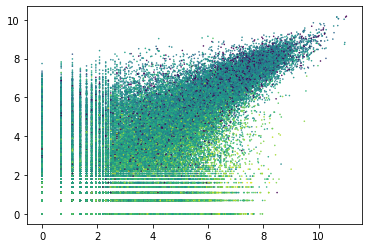

In [55]:
# Plot A673 vs HUVEC initiation levels with histone marks from H3K27me3
graph_withcorrelations('A673', 'HUVEC', 'H3K27me3')

Correlation between K562 & A673 with regards to K562 histone marks is 0.28963715048768846


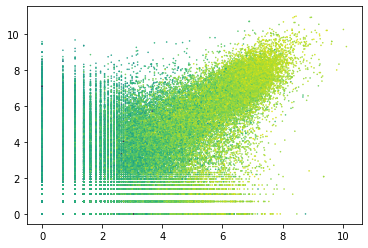

Correlation between K562 & A673 with regards to A673 histone marks is -0.2943936263454137


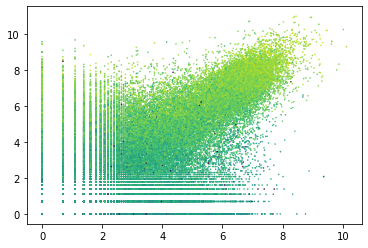

In [56]:
# Plot K562 vs A673 initiation levels with histone marks from H3K27ac
graph_withcorrelations('K562', 'A673', 'H3K27ac')

Correlation between K562 & HUVEC with regards to K562 histone marks is 0.2341995979055266


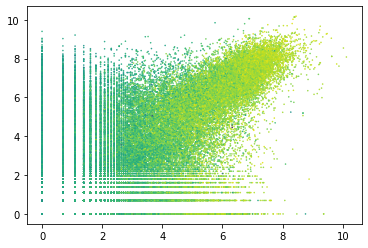

Correlation between K562 & HUVEC with regards to HUVEC histone marks is -0.4590376952107343


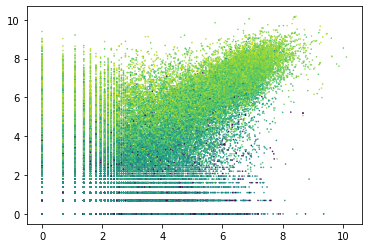

In [57]:
# Plot K562 vs HUVEC initiation levels with histone marks from H3K27ac
graph_withcorrelations('K562', 'HUVEC', 'H3K27ac')

Correlation between A673 & HUVEC with regards to A673 histone marks is 0.23962604225079787


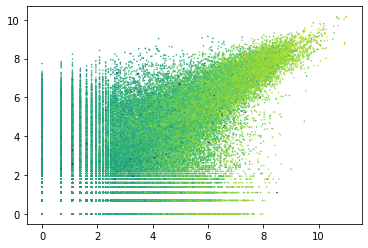

Correlation between A673 & HUVEC with regards to HUVEC histone marks is -0.4022218374577169


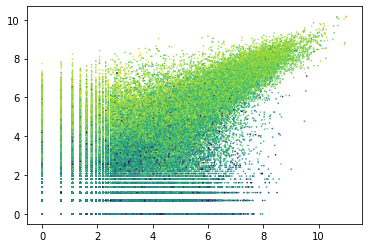

In [58]:
# Plot A673 vs HUVEC initiation levels with histone marks from H3K27ac
graph_withcorrelations('A673', 'HUVEC', 'H3K27ac')

Correlation between K562 & CACO2 with regards to K562 histone marks is 0.1145124586967342


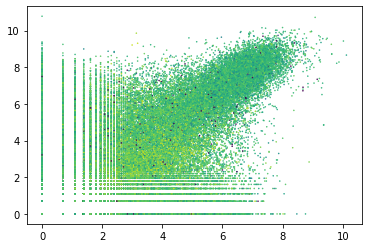

Correlation between K562 & CACO2 with regards to CACO2 histone marks is 0.04963620017250386


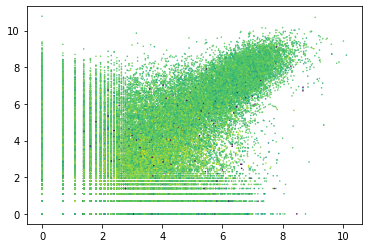

In [59]:
# Plot K562 vs CACO2 initiation levels with histone marks from H3K36me3
graph_withcorrelations('K562', 'CACO2', 'H3K36me3')

Correlation between K562 & A673 with regards to K562 histone marks is 0.1269766866316842


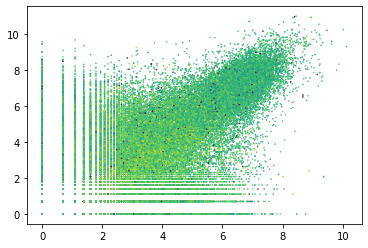

Correlation between K562 & A673 with regards to A673 histone marks is 0.05395827744715337


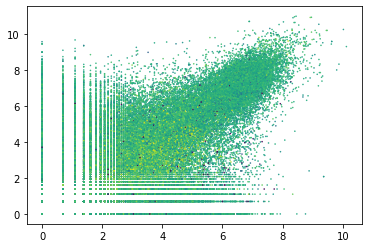

In [60]:
# Plot K562 vs A673 initiation levels with histone marks from H3K36me3
graph_withcorrelations('K562', 'A673', 'H3K36me3')

Correlation between K562 & HUVEC with regards to K562 histone marks is 0.08093864506388163


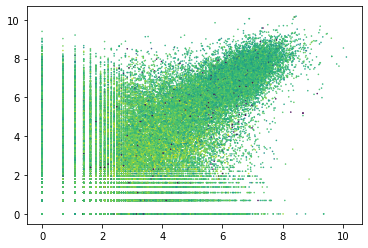

Correlation between K562 & HUVEC with regards to HUVEC histone marks is 0.0928585502807346


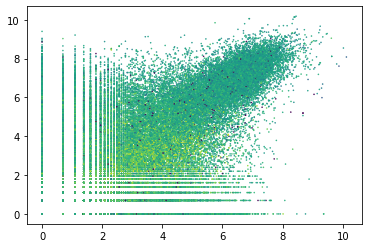

In [61]:
# Plot K562 vs HUVEC initiation levels with histone marks from H3K36me3
graph_withcorrelations('K562', 'HUVEC', 'H3K36me3')

Correlation between CACO2 & A673 with regards to CACO2 histone marks is 0.03520401353373167


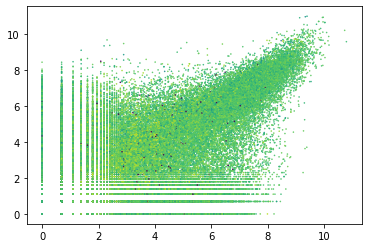

Correlation between CACO2 & A673 with regards to A673 histone marks is -0.051279081156350076


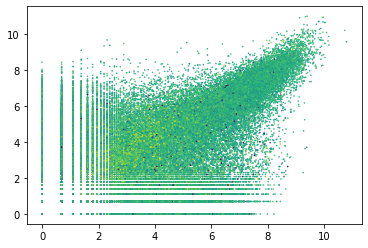

In [62]:
# Plot CACO2 vs A673 initiation levels with histone marks from H3K36me3
graph_withcorrelations('CACO2', 'A673', 'H3K36me3')

Correlation between CACO2 & HUVEC with regards to CACO2 histone marks is -0.03367004928126269


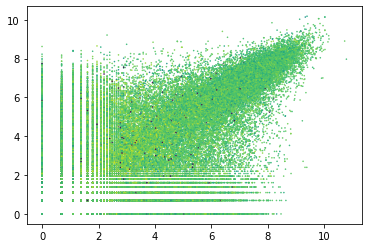

Correlation between CACO2 & HUVEC with regards to HUVEC histone marks is 0.010416302857367398


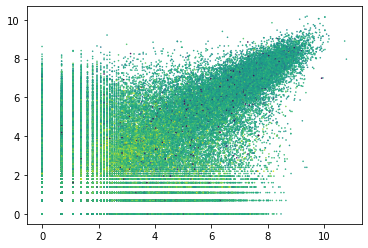

In [63]:
# Plot CACO2 vs HUVEC initiation levels with histone marks from H3K36me3
graph_withcorrelations('CACO2', 'HUVEC', 'H3K36me3')

Correlation between A673 & HUVEC with regards to A673 histone marks is 0.0251902531336789


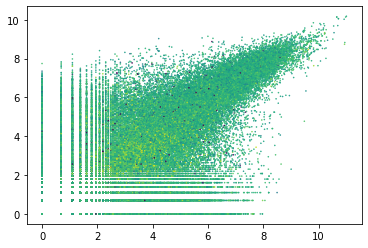

Correlation between A673 & HUVEC with regards to HUVEC histone marks is -0.00976848076664014


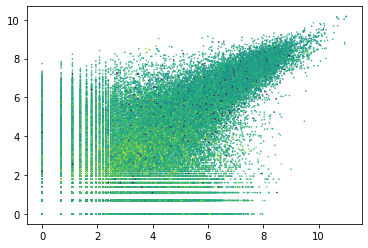

In [64]:
# Plot A673 vs HUVEC initiation levels with histone marks from H3K36me3
graph_withcorrelations('A673', 'HUVEC', 'H3K36me3')

Correlation between K562 & CACO2 with regards to K562 histone marks is 0.06370103782904836


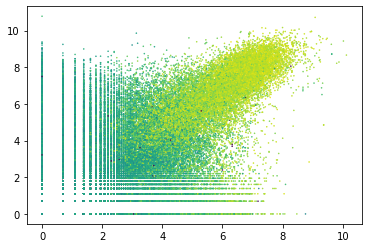

Correlation between K562 & CACO2 with regards to CACO2 histone marks is -0.16897688674648914


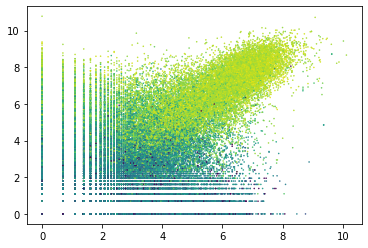

In [67]:
# Plot K562 vs CACO2 initiation levels with histone marks from H3K4me3
graph_withcorrelations('K562', 'CACO2', 'H3K4me3')

Correlation between K562 & A673 with regards to K562 histone marks is 0.13924076616349768


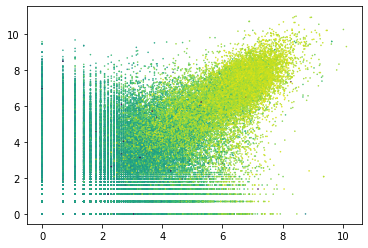

Correlation between K562 & A673 with regards to A673 histone marks is -0.08604269610776279


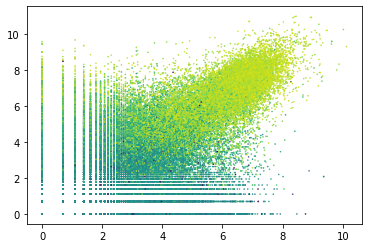

In [68]:
# Plot K562 vs A673 initiation levels with histone marks from H3K4me3
graph_withcorrelations('K562', 'A673', 'H3K4me3')

Correlation between K562 & HUVEC with regards to K562 histone marks is 0.0729366593052397


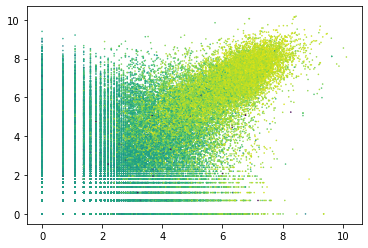

Correlation between K562 & HUVEC with regards to HUVEC histone marks is -0.1593930115965567


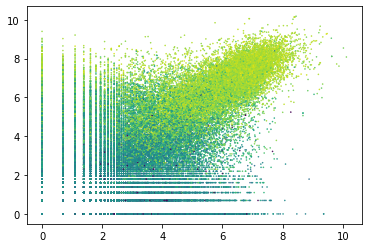

In [69]:
# Plot K562 vs HUVEC initiation levels with histone marks from H3K4me3
graph_withcorrelations('K562', 'HUVEC', 'H3K4me3')

Correlation between CACO2 & A673 with regards to CACO2 histone marks is 0.16173480041340968


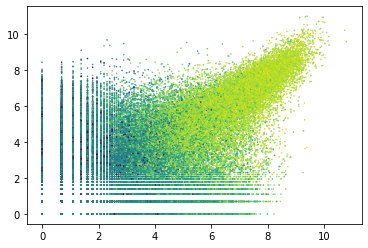

Correlation between CACO2 & A673 with regards to A673 histone marks is -0.021698658312959127


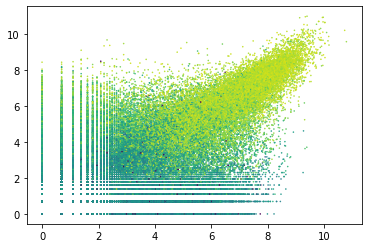

In [70]:
# Plot CACO2 vs A673 initiation levels with histone marks from H3K4me3
graph_withcorrelations('CACO2', 'A673', 'H3K4me3')

Correlation between CACO2 & HUVEC with regards to CACO2 histone marks is 0.08648933776350144


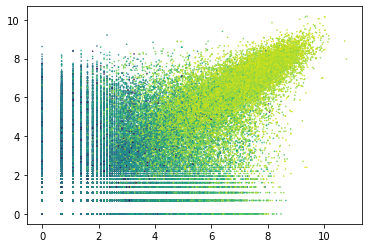

Correlation between CACO2 & HUVEC with regards to HUVEC histone marks is -0.08493447109105054


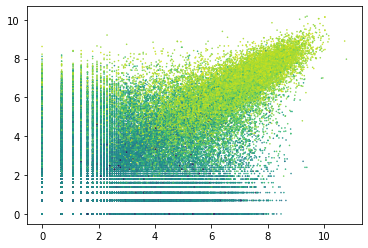

In [71]:
# Plot CACO2 vs HUVEC initiation levels with histone marks from H3K4me3
graph_withcorrelations('CACO2', 'HUVEC', 'H3K4me3')

Correlation between A673 & HUVEC with regards to A673 histone marks is -0.010831110424731658


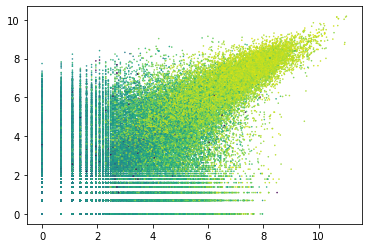

Correlation between A673 & HUVEC with regards to HUVEC histone marks is -0.15427126820803103


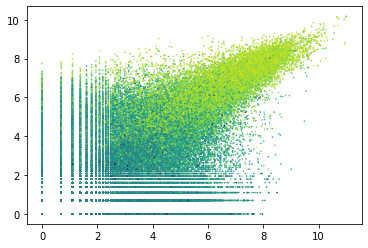

In [72]:
# Plot A673 vs HUVEC initiation levels with histone marks from H3K4me3
graph_withcorrelations('A673', 'HUVEC', 'H3K4me3')

Correlation between K562 & HUVEC with regards to K562 histone marks is 0.08762189687072663


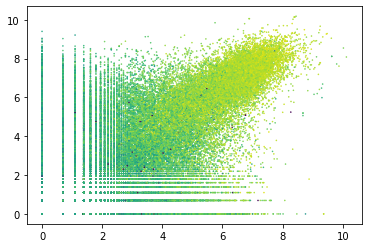

Correlation between K562 & HUVEC with regards to HUVEC histone marks is -0.32747512719048555


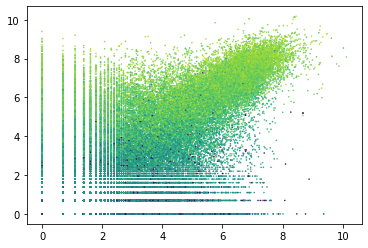

In [73]:
# Plot K562 vs HUVEC initiation levels with histone marks from H3K9ac
graph_withcorrelations('K562', 'HUVEC', 'H3K9ac')

Correlation between K562 & HUVEC with regards to K562 histone marks is 0.11365669491703265


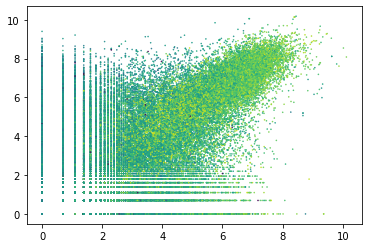

Correlation between K562 & HUVEC with regards to HUVEC histone marks is -0.07121358136767673


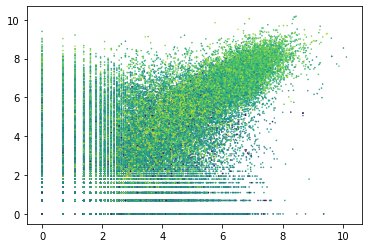

In [74]:
# Plot K562 vs HUVEC initiation levels with histone marks from H3K79me2
graph_withcorrelations('K562', 'HUVEC', 'H3K79me2')